## FAIRNESS BY REGULARIZATION

Here we will see how we can use the popular variance reduction technique in machine learning model to get a fair trained classifier. We will be using the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult) for our demonstration purpose.

### IMPORTNG THE NECESSARY LIBRARIES

We will be using the open-source [AIF360](https://github.com/Trusted-AI/AIF360) package to use several fairness based metrics.

In [1]:
import numpy as np
np.set_printoptions(suppress = True)
import pandas as pd

import matplotlib.pyplot as plt

# Importing the Dataset
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics.utils import compute_boolean_conditioning_vector
from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

### DATASET

In [2]:
priv_group = [{'sex':1}]
unpriv_group = [{'sex':0}]

In [3]:
data_adult = load_preproc_data_adult(['sex'])

### FAIRNESS BASED REGULARIZED CLASSIFIER

Here we will fit a regularized logistic regression classifier using different regularization terms for each trained model, to compare the results in terms of accuracy and fairness levels achieved by the model.

#### - EQUALISED ODDS REGULARIZATION

- **METHOD**

Here we will try to achieve a classifier with equalized odds using a regularization term in the loss function which has difference in the values of FPR and FNR for both the classes as shown below:

$$Loss(\theta;G,X)\ =\ -ll(\theta;G,X) + C_1|FPR(G=f)-FPR(G=m)|\\ + C_2|FNR(G=f)-FNR(G=m)| + \frac{1}{2}C_3||\theta||_2^2$$
where, 
$$ll(\theta;G,X) = \sum_{i=1}^n y_i\log(S(x_i^T.\theta))+(1-y_i)\log(1-S(x_i^T.\theta))\\ S(x) = \frac{1}{1+e^{-x}}$$
and $\theta$ represents the weights and biases of the model and $G,X$ is the given data.

We want to find the optimal value of $\theta^*$ such that,
$\DeclareMathOperator*{\argmin}{arg\,min}$
$$\theta^* = \argmin_\theta Loss(\theta;G,X)$$

To solve this above optimization problem, we use gradient descent, starting with an initial value of $\theta_0$, we update the weights and biases as follows,
$$\theta^{n+1} = \theta^{n} - lr\cdot \frac{\partial Loss(\theta;G,X)}{\partial \theta}$$
where, $lr$ is the learning rate.

We will use the common variant of the gradient descent, Stochastic Gradient Descent.

To train our model, we will split our data into 2 parts i.e. training data and a test data

In [85]:
dset_raw_trn, dset_raw_tst = data_adult.split([0.7], shuffle=True)

In [86]:
dset_trn_pred = dset_raw_tst.copy(deepcopy=True)

Taking a look at the fairness metrics for the test data and the proportion of protected group and labels, we get:

In [87]:
def plot_prop_prtced_grp_lab(data, title="", figsize=(10,8)):
    feature_idx = np.where(np.array(data.feature_names) == data.protected_attribute_names[0])[0][0]
    n_p_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_unp_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_p_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    n_unp_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    plt.figure(figsize=figsize)
    xlocs = [i for i in range(4)]
    y = [n_p_fav/(n_p_fav+n_p_unfav), n_unp_fav/(n_unp_fav+n_unp_unfav), n_p_unfav/(n_p_fav+n_p_unfav), n_unp_unfav/(n_unp_fav+n_unp_unfav)]
    plt.bar(['priv grp,fav label','unpriv grp,fav label', 'priv grp,unfav label', 'unpriv grp,unfav label'], y)
    for i, v in enumerate(y):
        plt.text(xlocs[i] - 0.05, v + 0.01, str(round(v,2)))
    plt.title(title)
    plt.show()

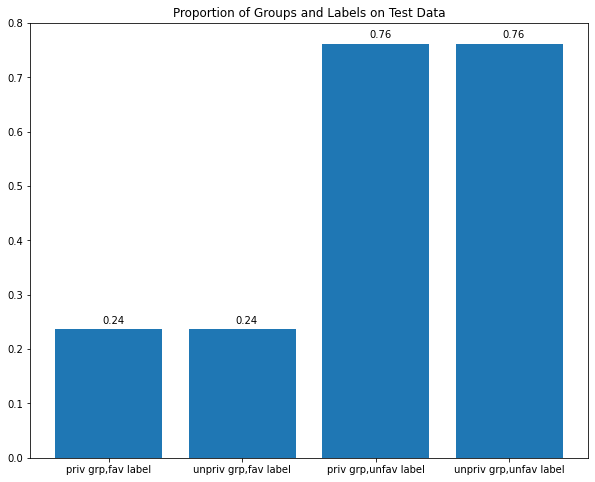

In [88]:
plot_prop_prtced_grp_lab(dset_raw_tst, "Proportion of Groups and Labels on Test Data")

In [89]:
dset_raw_tst_metrics = BinaryLabelDatasetMetric(dset_raw_tst,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_raw_tst_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_raw_tst_metrics.disparate_impact())
print("Consistency:",dset_raw_tst_metrics.consistency()[0])

Statistical Parity Difference: -0.2011591902342209
Disparate Impact: 0.3404494741177242
Consistency: 0.7363679792534046


- **FITTING MODELS**
    - Only $L2$ regularization (Model: $M$)
    - Equalized Odd & $L2$ Regularization (Model: $M_F$)

In [90]:
scaler = StandardScaler()
dset_trn = scaler.fit_transform(dset_raw_trn.features)
y_trn = dset_raw_trn.labels.ravel()
dset_trn = torch.from_numpy(dset_trn).float()
y_trn = torch.from_numpy(y_trn).float()
y_trn = y_trn.view(y_trn.shape[0], 1)

In [91]:
class Log_Reg(nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.linear = nn.Linear(size_in, 1)
    def forward(self, x):
        prob_pred = torch.sigmoid(self.linear(x))
        return prob_pred

In [92]:
M = Log_Reg(len(dset_raw_trn.feature_names))
M_F = Log_Reg(len(dset_raw_trn.feature_names))

In [76]:
num_epochs = 1000
learning_rate = 0.01
optimizer_M = torch.optim.SGD(M.parameters(), lr= learning_rate)
optimizer_M_F = torch.optim.SGD(M_F.parameters(), lr= learning_rate)
criterion = nn.BCELoss()
criterion_f = nn.BCELoss()

In [ ]:
def loss_f(p_pred, y, fpr_diff, fnr_diff, C1=1, C2=1):
    return criterion_f(p_pred, y) + C1*fpr_diff + C2*fnr_diff

In [77]:
# Training M
for epoch in range(num_epochs):
    y_pred = M(dset_trn)
    loss= criterion(y_pred, y_trn)
    
    loss.backward()
    optimizer_M.step()
    
    optimizer_M.zero_grad()
    
    if (epoch+1) % 100== 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 100, loss = 0.6181
epoch: 200, loss = 0.5518
epoch: 300, loss = 0.5133
epoch: 400, loss = 0.4894
epoch: 500, loss = 0.4737
epoch: 600, loss = 0.4628
epoch: 700, loss = 0.4549
epoch: 800, loss = 0.4490
epoch: 900, loss = 0.4446
epoch: 1000, loss = 0.4411


In [ ]:
# Training M
for epoch in range(num_epochs):
    p_pred = M_F(dset_trn)
    
    dset_trn_pred.labels = (p_pred > 0.5).numpy().astype(float)
    mod_metrics = ClassificationMetric(dset_raw_trn, dset_trn_pred,
                                            unprivileged_groups=unpriv_group,
                                            privileged_groups=priv_group)
    
    loss= loss_f(p_pred, y_trn, mod_metrics.false_positive_rate_difference() , mod_metrics.false_negative_rate_difference())
    
    loss.backward()
    optimizer_M_F.step()
    
    optimizer_M_F.zero_grad()
    
    if (epoch+1) % 100== 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])